## Paleoproterozoic d13C, oxygenation, and glaciations
This notebook can be used to reproduce all components of Fig. 2, including: 
- Inferred density of d13C observations over time
- Paleoproterozoic d13C inference
- Age of S-MIF and S-MDf observations from basins included in the inference model 
- Age of glacial diamictite units from basins included in the infernece model 
- Prior and posterior age ranges for each basin included in the inference model

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import stratmc
import warnings 

import scipy.stats as stats

from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import gaussian_kde
from tqdm.notebook import tqdm

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Avenir']
rcParams.update({
    "text.usetex": False
})

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

## Import data

In [2]:
section_metadata = pd.read_csv('data/paleoproterozoic_section_metadata.csv')

sample_df, ages_df =  stratmc.data.load_data('data/paleoproterozoic_data', 
                                             'data/paleoproterozoic_ages', 
                                             combine_no_superposition = False)

sample_df_downsampled = stratmc.data.load_object('data/downsampling/downsampled_sample_df')


In [3]:
priority_1_sections = section_metadata[(section_metadata['Inversion priority level']==1) & (~section_metadata['Included in composite section?'])]['section']
priority_2_sections = section_metadata[(section_metadata['Inversion priority level']==2) & (~section_metadata['Included in composite section?'])]['section']
priority_3_sections = section_metadata[(section_metadata['Inversion priority level']==3) & (~section_metadata['Included in composite section?'])]['section']
priority_4_sections = section_metadata[(section_metadata['Inversion priority level']==4) & (~section_metadata['Included in composite section?'])]['section']

include_sections = np.concatenate([priority_1_sections, priority_2_sections])

## Load Paleoproterozoic d13C inference results

In [23]:
# load the 'all-data' inference results
full_trace = stratmc.data.load_trace("traces/" + "paleoproterozoic_d13C_trace")

## Excursion timing statistics

In [24]:
# load pre-calculated excursion statistics: timing and d13C value at onset and peak
onset_list = stratmc.data.load_object('data/excursion_stats/excursion_onset')
onset_d13C_list = stratmc.data.load_object('data/excursion_stats/excursion_onset_d13C')

peak_list = stratmc.data.load_object('data/excursion_stats/excursion_peak')
peak_d13C_list = stratmc.data.load_object('data/excursion_stats/excursion_peak_d13C')

termination_list = stratmc.data.load_object('data/excursion_stats/excursion_termination')
termination_d13C_list = stratmc.data.load_object('data/excursion_stats/excursion_termination_d13C')

## Elevated d13C interval
Calculate the posterior probability that d13C exceeds 2 permil (approximate upper bound for 'baseline' d13C values)

In [25]:
# color palette for plotting
p_d13C_thresh_palette = sns.color_palette("blend:white,#8fbc8f", as_cmap=True) 

ages = full_trace.X_new.X_new.values

# d13C signal inference
proxy_pred = az.extract(full_trace.posterior_predictive)["f_pred_" + "d13c"].values

# d13C threshold = 2 permil
p_d13C_thresh = [] 
thresh = 2

# for each age, count the fraction of posterior draws where d13C exceeds the threshold
for k in range(proxy_pred.shape[0]): 
    p_d13C_thresh.append(len(np.where(proxy_pred[k, :] >= thresh)[0])/proxy_pred.shape[1])
    
p_d13C_thresh = np.array(p_d13C_thresh)

# define bin edges for plotting
x_edges_p_d13C = list(ages) + [ages[-1] + 1]
x_edges_p_d13C = np.array(x_edges_p_d13C) - 0.5

x_edges_p_d13C = x_edges_p_d13C.reshape(1, x_edges_p_d13C.shape[0])
x_edges_2d_p_d13C = np.repeat(x_edges_p_d13C, 2, axis = 0)

y_edges_2d_p_d13C = np.ones_like(x_edges_2d_p_d13C)
y_edges_2d_p_d13C[1, :] = -5.5
y_edges_2d_p_d13C[0, :] = -6

In [26]:
over_idx_66 = np.where(p_d13C_thresh >= 0.66)[0]

print('Likely onset of elevated d13C interval (at least 66% prob > 2 permil):', ages[over_idx_66[-1]])
print('Likely termination of elevated d13C interval (last age with at least 66% prob > 2 permil):', ages[(p_d13C_thresh <= 0.66) & (ages < ages[over_idx_66[-1]])][-1])


Likely onset of elevated d13C interval (at least 66% prob > 2 permil): 2368
Likely termination of elevated d13C interval (last age with at least 66% prob > 2 permil): 2042


## Data density over time
Calculate the posterior number of observations in 10 Myr time bins:

In [27]:
# 10 Myr bins
bin_edges = list(full_trace.X_new.X_new.values[::10])

# initialize histogram with first section
section = include_sections[0]

section_df = sample_df_downsampled[sample_df_downsampled['section'] == section]

# only count observations that were included in the inference model
include_idx =  (~section_df['Exclude?'].values) & (~np.isnan(section_df['d13c'].values))

# sample age counts for section
hist_included, x_edges = np.histogram(az.extract(full_trace.posterior)[section + '_ages'][include_idx, :], bins = bin_edges)

# iterate over rest of sections, adding sample counts to histogram
for section in tqdm(include_sections[1:]): 
    section_df = sample_df_downsampled[sample_df_downsampled['section'] == section]
    include_idx =  (~section_df['Exclude?'].values) & (~np.isnan(section_df['d13c'].values)) #~section_df['Exclude?'].values
    hist_section_included, x_edges = np.histogram(az.extract(full_trace.posterior)[section + '_ages'][include_idx, :], bins = bin_edges)

    hist_included += hist_section_included

# boundaries for plotting
x_edges = x_edges.reshape(1, x_edges.shape[0])
x_edges_2d = np.repeat(x_edges, 2, axis = 0)
x_edges_2d.shape

y_edges_2d = np.ones_like(x_edges_2d).astype(float)
y_edges_2d[0, :] = 10
y_edges_2d[1, :] = 9.5

  0%|          | 0/75 [00:00<?, ?it/s]

In [28]:
# compute average number of draws per age bin (divide histogram counts by total # of draws)
draws = full_trace.posterior.draw.values
chains = full_trace.posterior.chain.values

hist_included = hist_included/(len(draws) * len(chains))

## Basin age ranges
Compute posterior age ranges for each basin. The median age is bracketed by the median ages of the min/max age constraints (either geochronology or relevant posterior section age models), while the 95% envelope is bracketed by the 2.5th and 97.5th percentile of the minimum and maximum ages, respectively.

In [29]:
# compute median and 95% envelopes for each stratigraphic section 
lower_5 = {}
lower_50 = {}
upper_50 = {}
upper_95 = {}
prior_lower_5 = {}
prior_upper_95 = {}
prior_lower_50 = {}
prior_upper_50 = {}
 
for section in include_sections:  
    # posterior age ranges
    sec_ages = az.extract(full_trace.posterior)[section + '_ages'].values
    lower_5[section] = np.percentile(sec_ages[-1, :].ravel(), 2.5)
    lower_50[section] = np.percentile(sec_ages[-1, :].ravel(), 50)
    upper_50[section] = np.percentile(sec_ages[0, :].ravel(), 50)
    upper_95[section] = np.percentile(sec_ages[0, :].ravel(), 97.5)
    
    # prior age ranges (geochronology)
    sec_ages = ages_df[ages_df['section']==section]
    min_idx = np.argmin(sec_ages['age'])
    max_idx = np.argmax(sec_ages['age'])
    prior_lower_50[section] = sec_ages['age'].values[min_idx]
    prior_lower_5[section] = sec_ages['age'].values[min_idx] - 2 * sec_ages['age_std'].values[min_idx] 
    prior_upper_95[section] = sec_ages['age'].values[max_idx] + 2 * sec_ages['age_std'].values[max_idx] 
    prior_upper_50[section] = sec_ages['age'].values[max_idx]
    

In [30]:
# list of supergroups to calculate age ranges for
supergroups = section_metadata['supergroup/association'][((section_metadata['Inversion priority level'] == 1) | (section_metadata['Inversion priority level'] == 2))].unique()

# list of groups to calculate age ranges for (only if no supergroup associated with section)
groups = section_metadata[(section_metadata['supergroup/association'].astype(str).values == 'nan') & ((section_metadata['Inversion priority level'] == 1) | (section_metadata['Inversion priority level'] == 2))]['group'].unique()

supergroups = supergroups.astype(str)
supergroups = supergroups[supergroups != 'nan']
groups = groups[groups != 'nan']

supergroup_sections = {} 
supergroup_labels = []

# grab list of sections associated with each supergroup
for supergroup in supergroups:
    super_df = section_metadata[(section_metadata['supergroup/association'] == supergroup) & ((section_metadata['Inversion priority level'] == 1) | (section_metadata['Inversion priority level'] == 2))]
    supergroup_sections[supergroup] = super_df['section'].values.astype(str).ravel()
    supergroup_labels.append(supergroup)
    
    super_idx = sample_df['section'].isin(supergroup_sections[supergroup])
    
# grab list of sections associated with each group
for supergroup in groups: 
    super_df = section_metadata[(section_metadata['group'] == supergroup) & ((section_metadata['Inversion priority level'] == 1) | (section_metadata['Inversion priority level'] == 2))]
    supergroup_sections[supergroup] = super_df['section'].values.astype(str).ravel()
    supergroup_labels.append(supergroup)
    
prior_max_sort_list = [] 
    
lower_5 = {}
lower_50 = {}
upper_50 = {}
upper_95 = {}
prior_lower_5 = {}
prior_upper_95 = {}
prior_lower_50 = {}
prior_upper_50 = {}

# calculate prior and posterior age range for each basin 
for supergroup in tqdm(supergroup_labels): 
    youngest_ages = np.array([])
    min_radio_ages = [] 
    min_radio_age_stds = [] 
    max_radio_ages = [] 
    max_radio_age_stds = [] 
    
    # iterate over sections within current supergroup, and extract ages of youngest and oldest sample from each section
    for i, section in enumerate(supergroup_sections[supergroup]): 
        
        # posterior section age models
        sec_ages = az.extract(full_trace.posterior)[section + '_ages'].values
    
        # grab oldest and youngest posterior sample ages for current section, and add to list (of oldest/youngest samples from each section)
        if i == 0: 
            youngest_sample_ages = sec_ages[-1, :].reshape(1, sec_ages.shape[1])
            oldest_sample_ages = sec_ages[0, :].reshape(1, sec_ages.shape[1])
            
        else: 
            oldest_sample_ages = np.vstack([oldest_sample_ages,  sec_ages[0, :]])
            youngest_sample_ages = np.vstack([youngest_sample_ages,  sec_ages[-1, :]])
            
        # grab minimum and maximum geochronological age constraints for current section, and add to list
        sec_ages_df = ages_df[(ages_df['section']==section) & ~(ages_df['Exclude?'])]
        
        min_idx = np.argmin(sec_ages_df['age'].values)
        max_idx = np.argmax(sec_ages_df['age'].values)
        
        min_radio_ages.append(sec_ages_df['age'].values[min_idx])
        max_radio_ages.append(sec_ages_df['age'].values[max_idx])
        
        min_radio_age_stds.append(sec_ages_df['age_std'].values[min_idx])
        max_radio_age_stds.append(sec_ages_df['age_std'].values[max_idx])
        
    min_radio_ages = np.array(min_radio_ages)
    max_radio_ages = np.array(max_radio_ages)
    min_radio_age_stds = np.array(min_radio_age_stds)
    max_radio_age_stds = np.array(max_radio_age_stds)
    
    # for each posterior draw, grab ages of oldest and youngest samples from supergroup (using compiled ages from all constituent sections)
    youngest_sample_ages = np.min(youngest_sample_ages, axis = 0)
    oldest_sample_ages = np.max(oldest_sample_ages, axis = 0)
        
    # save median and 95% posterior age envelope for each supergroup (2.5th percentile of youngest ages across all draws, 97.5th percentile of oldest ages)
    lower_5[supergroup] = np.percentile(youngest_sample_ages, 2.5)
    lower_50[supergroup] = np.percentile(youngest_sample_ages, 50)
    upper_50[supergroup] = np.percentile(oldest_sample_ages, 50)
    upper_95[supergroup] = np.percentile(oldest_sample_ages, 97.5)
    
    # get minimum geochronological (prior) age constraint for entire supergroup
    min_idx = np.argmin(min_radio_ages)
    
    # get maximum geochronological (prior) age constraint for entire supergroup
    max_idx = np.argmax(max_radio_ages)
    
    # save 95% prior age envelope for each supergroup
    prior_lower_50[supergroup] = min_radio_ages[min_idx]
    prior_lower_5[supergroup] = min_radio_ages[min_idx] - 2 * min_radio_age_stds[min_idx] 
    prior_upper_95[supergroup] = max_radio_ages[max_idx] + 2 * max_radio_age_stds[max_idx] 
    prior_upper_50[supergroup] = max_radio_ages[max_idx]
    
    # list of max ages for sorting
    prior_max_sort_list.append(max_radio_ages[max_idx])
    
# sort supergroups by maximum age
sort_idx = np.flip(np.argsort(prior_max_sort_list))
supergroup_labels = np.array(supergroup_labels)[sort_idx]

  0%|          | 0/30 [00:00<?, ?it/s]

In [31]:
# colors for plotting 
supergroup_pal = sns.color_palette('blend:gray,gray', n_colors = len(supergroup_labels)) 

# re-order supergroups for plotting 
supergroup_labels = ['San Jose Greenstone Belt',
                    'Transvaal Supergroup (Griqualand West)', 
                    'Transvaal Supergroup',
                    'Transvaal Supergroup (Bushveld)',
                    'Mount Bruce Supergroup',
                    'Union Island Group', 
                    'Minas Supergroup', 
                    'Snowy Pass Supergroup',
                    'Karasjok - Kittilä Greenstone Belt', 
                    'Hutuo Supergroup',
                    'Pechenga Greenstone Belt', 
                    'Imandra-Varzuga Greenstone Belt',
                    'Raipais Supergroup', 
                    'Huronian Supergroup', 
                    'Aravalli Supergroup',
                    'Peräpohja Schist Belt',
                    'Kuusamo Schist Belt',
                    'Marquette Range Supergroup',
                    'Kaniapiskau Supergroup/Labrador Trough',
                    'Magondi Supergroup',
                    'North China Craton', 
                    'Franceville Basin', 
                    'Yerrida Basin',
                    'Kalix Greenstone Belt', 
                    'Mistassini Group', 
                    'Belcher Group',
                    'Kiihtelysvaara Area', 
                    'Earaheedy Basin', 
                    'Onega Basin',
                    'Hurwitz Group']

## Sulfur isotope data

In [32]:
sulfur_data = pd.read_csv('data/sulfur_summary.csv')

sulfur_data.dropna(subset = ['Classification (MIF or MDF)'], inplace = True)


In [33]:
include_basins = ['Transvaal Supergroup - Griqualand West', 
                'Transvaal Supergroup - Transvaal Basin', 
                'Pilbara Craton',
                'Imandra-Varzuga Greenstone Belt',
                'Huronian Supergroup', 
                'Peräpohja Schist Belt',
                'Marquette Range Supergroup',
                'Franceville Basin', 
                'Belcher Group',
                'Onega Basin']


# link S isotope observations (keys) to names of formations in d13C data (values)
link_to_formation = {'Costello Formation': 'Costello Formation', 
                     'Seidorechka Sedimentary Formation': 'Seidorechka Sedimentary Formation', 
                    'Zaonega Formation': 'Zaonega Formation', 
                    'Tulomozero Formation': 'Tulomozero Formation',
                    'Sompujärvi Formation': 'Sompujärvi Formation',
                     'Kazput Formation': 'Kazput Formation', 
                     'Boomplaas Formation': 'Boomplaas Formation',
                     'Lucknow Formation': 'Lucknow Formation', 
                     'Lokammona Formation': 'Lokammona Formation', 
                     'Mooidraai Formation': 'Mooidraai Formation', 
                     'Silverton Formation': 'Silverton Formation', 
                     'Houtenbek Formation': 'Houtenbek Formation'
                    }

# link S isotope observations (keys) to names of members in d13C data (values)
link_to_member = {'Campbellrand Subgroup': 'Campbellrand Subgroup'}


### Compute the posterior age of each sulfur isotope observation 
The computed posterior ages are included in `sulfur_summary.csv`. Run this cell to re-compute.

In [34]:
## compute the posterior age range of each sulfur isotope observation 

# calculate max and min ages based on the posterior age models of under and overlying stratigraphic sections
sulfur_data['Max. posterior age (median)'] = np.nan
sulfur_data['Max. posterior age (97.5%)'] = np.nan
sulfur_data['Min. posterior age (median)'] = np.nan
sulfur_data['Min. posterior age (2.5%)'] = np.nan

# separately calculate max and min ages based on co-eval sections (i.e., d13C data from the same formation as the S-MIF data) 
sulfur_data['Max. posterior age - co-eval (median)'] = np.nan
sulfur_data['Max. posterior age - co-eval (97.5%)'] = np.nan
sulfur_data['Min. posterior age - co-eval (median)'] = np.nan
sulfur_data['Min. posterior age - co-eval (2.5%)'] = np.nan

# iterate over sulfur isotope observations
for i in range(sulfur_data.shape[0]): 
    
    if (sulfur_data.loc[i]['Supergroup/Association'] in include_basins) and (sulfur_data.loc[i]['Formation'] != 'Duitschland Formation') and (sulfur_data.loc[i]['Formation'] != 'Kungarra Formation'):
        
        # check if the maximum age for the S observation is constrained by older stratigraphic sections
        if str(sulfur_data.loc[i]['Older sections']) != 'nan': 
            older_sections = list([sulfur_data.loc[i]['Older sections']])
            older_sections = np.array([x.strip() for x in older_sections[0].split(',')])
            
            older_sections = [section for section in older_sections if section in include_sections]
            
        else: 
            older_sections = [] 

        # check if the minimum age for the S observation is constrained by younger stratigraphic sections
        if str(sulfur_data.loc[i]['Younger sections']) != 'nan': 
            younger_sections = list([sulfur_data.loc[i]['Younger sections']])
            younger_sections = np.array([x.strip() for x in younger_sections[0].split(',')])
            younger_sections = [section for section in younger_sections if section in include_sections]
        
        else: 
            younger_sections = [] 
            
        # check if the age of the S observation is constrained by co-eval sections (i.e., through the same formation)
        if str(sulfur_data.loc[i]['Co-eval sections']) != 'nan': 
            coeval_sections = list([sulfur_data.loc[i]['Co-eval sections']])
            coeval_sections = np.array([x.strip() for x in coeval_sections[0].split(',')])

            coeval_sections = [section for section in coeval_sections if section in include_sections]

        else: 
            coeval_sections = [] 
            
        # if the max age is constrained by older sections, compute posterior maximum age
        if len(older_sections) > 0: 
            # iterate over older sections
            for k, section in enumerate(older_sections): 
                sec_ages = az.extract(full_trace.posterior)[section + '_ages'].values

                # get age of youngest underlying sample, which provides the most conservative maximum age for the S observation
                if k == 0: 
                    youngest_sample_ages = sec_ages[-1, :]

                else: 
                    youngest_sample_ages = np.vstack([youngest_sample_ages,  sec_ages[-1, :]])
                    
            if len(youngest_sample_ages.shape) == 1: 
                youngest_sample_ages = youngest_sample_ages.reshape((1, youngest_sample_ages.shape[0]))
                 
            # tightest maximum age = youngest underlying sample (for each posterior draw) 
            youngest_sample_ages = np.min(youngest_sample_ages, axis = 0)
            
            # save median inferred maximum age (i.e., median of youngest underlying sample ages)
            sulfur_data['Max. posterior age (median)'].loc[i] = np.percentile(youngest_sample_ages, 50)
            
            # save 97.5 percentile maximum age (i.e., 97.5 percentile of youngest underlying sample ages)
            sulfur_data['Max. posterior age (97.5%)'].loc[i] = np.percentile(youngest_sample_ages, 97.5)
            
        # if the min age is constrained by younger sections, compute posterior minimum age
        if len(younger_sections) > 0: 
            # iterate over younger sections
            for k, section in enumerate(younger_sections): 
                sec_ages = az.extract(full_trace.posterior)[section + '_ages'].values
                
                # grab the oldest sample from each overlying section (which provides a minimum age constraint for the diamictite) 
                if k == 0: 
                    oldest_sample_ages = sec_ages[0, :]

                else: 
                    oldest_sample_ages = np.vstack([oldest_sample_ages,  sec_ages[0, :]])
   
            if len(oldest_sample_ages.shape) == 1: 
                oldest_sample_ages = oldest_sample_ages.reshape((1, oldest_sample_ages.shape[0]))
                      
            # tightest minimum age = oldest overlying sample (for each posterior draw)
            oldest_sample_ages = np.max(oldest_sample_ages, axis = 0)

            # save median inferred minimum age (i.e., median of oldest overlying sample ages)
            sulfur_data['Min. posterior age (median)'].loc[i] = np.percentile(oldest_sample_ages, 50)
            
            # save 2.5 percentile minimum age (i.e., 2.5 percetile of oldest overlying sample ages)
            sulfur_data['Min. posterior age (2.5%)'].loc[i] = np.percentile(oldest_sample_ages, 2.5)
            
        # compute age ranges for co-eval sections that are linked to specific formations or members
        if len(coeval_sections) > 0: 
            # grab age if S observation is from same formation as d13C data
            if sulfur_data.loc[i]['Formation'] in list(link_to_formation.keys()): 
                for k, section in enumerate(coeval_sections): 
                    section_df = sample_df_downsampled[sample_df_downsampled['section'] == section]
                    sec_ages = az.extract(full_trace.posterior)[section + '_ages'].values
                    keep_idx = section_df['Unit'] == link_to_formation[sulfur_data.loc[i]['Formation']]
                    sec_ages = sec_ages[keep_idx, :]
                    
                    # grab ages of the oldest and youngest d13C observations from matching interval
                    if k == 0: 
                        oldest_sample_ages = sec_ages[0, :]
                        youngest_sample_ages = sec_ages[-1, :]
                        
                    else: 
                        oldest_sample_ages = np.vstack([oldest_sample_ages,  sec_ages[0, :]])
                        youngest_sample_ages = np.vstack([youngest_sample_ages,  sec_ages[-1, :]])
                    
            # grab age if S observation is from same member as d13C data        
            elif sulfur_data.loc[i]['Formation'] in list(link_to_member.keys()): 
                for k, section in enumerate(coeval_sections): 
                    section_df = sample_df_downsampled[sample_df_downsampled['section'] == section]
                    sec_ages = az.extract(full_trace.posterior)[section + '_ages'].values
                    keep_idx = section_df['Member'] == link_to_member[sulfur_data.loc[i]['Formation']]
                    sec_ages = sec_ages[keep_idx, :]
                    
                    # grab ages of the oldest and youngest d13C observations from matching interval
                    if k == 0: 
                        oldest_sample_ages = sec_ages[0, :]
                        youngest_sample_ages = sec_ages[-1, :]
                        
                    else: 
                        oldest_sample_ages = np.vstack([oldest_sample_ages,  sec_ages[0, :]])
                        youngest_sample_ages = np.vstack([youngest_sample_ages,  sec_ages[-1, :]])       
            
            # if the S observation is not linked to a specific formation, instead link to entire section
            else: 
                for k, section in enumerate(coeval_sections): 
                    section_df = sample_df_downsampled[sample_df_downsampled['section'] == section]
                    sec_ages = az.extract(full_trace.posterior)[section + '_ages'].values
                    
                    if k == 0: 
                        oldest_sample_ages = sec_ages[0, :]
                        youngest_sample_ages = sec_ages[-1, :]
                        
                    else: 
                        oldest_sample_ages = np.vstack([oldest_sample_ages,  sec_ages[0, :]])
                        youngest_sample_ages = np.vstack([youngest_sample_ages,  sec_ages[-1, :]])
                        
            if len(youngest_sample_ages.shape) == 1: 
                youngest_sample_ages = youngest_sample_ages.reshape((1, youngest_sample_ages.shape[0]))

            if len(oldest_sample_ages.shape) == 1: 
                oldest_sample_ages = oldest_sample_ages.reshape((1, oldest_sample_ages.shape[0]))   

            # find the youngest underlying sample age (max age for S observation) and oldest overlying sample age (min age for S observation)
            oldest_sample_ages = np.max(oldest_sample_ages, axis = 0)
            youngest_sample_ages = np.min(youngest_sample_ages, axis = 0)
            
            # print(sulfur_data.loc[i]['Formation'], np.percentile(youngest_sample_ages, 5))
                        
            # store median and 95% envelopes in 'co-eval' constraint columns
            sulfur_data['Min. posterior age - co-eval (2.5%)'].loc[i] = np.percentile(youngest_sample_ages, 2.5)
            sulfur_data['Min. posterior age - co-eval (median)'].loc[i] = np.percentile(youngest_sample_ages, 50)
            
            sulfur_data['Max. posterior age - co-eval (97.5%)'].loc[i] = np.percentile(oldest_sample_ages, 97.5)
            sulfur_data['Max. posterior age - co-eval (median)'].loc[i] = np.percentile(oldest_sample_ages, 50)
            
### custom constraints for sections with more complex stratigraphic relationships to S isotope data

## Kungarra Formation - bracketed by samples at 258 (below MBM sample --> max age) and 758 (above MBM sample --> min age) meters in Turee Creek Composite
idx = np.where((sulfur_data['Formation'] == 'Kungarra Formation') & (sulfur_data['Member'] == 'Below MBM'))[0]

section = 'Turee Creek Composite'
section_df = sample_df_downsampled[sample_df_downsampled['section'] == section]

sec_ages = az.extract(full_trace.posterior)[section + '_ages'].values

# below the MBM 
idx = np.where((sulfur_data['Formation'] == 'Kungarra Formation') & (sulfur_data['Member'] == 'Below MBM'))[0]

keep_idx = section_df['height'] < 259
sec_ages = sec_ages[keep_idx, :]

youngest_sample_ages = sec_ages[-1, :]
oldest_sample_ages = sec_ages[0, :]

sulfur_data['Min. posterior age - co-eval (2.5%)'].iloc[idx] = np.percentile(youngest_sample_ages, 2.5)
sulfur_data['Min. posterior age - co-eval (median)'].iloc[idx] = np.percentile(youngest_sample_ages, 50)
sulfur_data['Max. posterior age - co-eval (97.5%)'].iloc[idx] = np.percentile(oldest_sample_ages, 97.5)
sulfur_data['Max. posterior age - co-eval (median)'].iloc[idx] = np.percentile(oldest_sample_ages, 50)

# MBM 
idx = np.where((sulfur_data['Formation'] == 'Kungarra Formation') & (sulfur_data['Member'] == 'Meteorite Bore Member'))[0]

youngest_sample_ages = sec_ages[-1, :] # highest sample below the MBM = max age for MBM

sulfur_data['Max. posterior age (median)'].iloc[idx] = np.percentile(youngest_sample_ages, 50)
sulfur_data['Max. posterior age (97.5%)'].iloc[idx] = np.percentile(youngest_sample_ages, 97.5)

keep_idx = (section_df['height'] > 259)

sec_ages = az.extract(full_trace.posterior)[section + '_ages'].values
sec_ages = sec_ages[keep_idx, :]

oldest_sample_ages = sec_ages[0, :] # oldest sample above the MBM = min age for MBM

sulfur_data['Min. posterior age (median)'].iloc[idx] = np.percentile(oldest_sample_ages, 50)
sulfur_data['Min. posterior age (2.5%)'].iloc[idx] = np.percentile(oldest_sample_ages, 2.5)
 
## Duitschland Formation. Beneath MDU (mid-Duitschland Unconformity) member = 244 to 420 m, Above MDU member = 420 to 961 meters

# Below MDU 
idx = np.where((sulfur_data['Formation'] == 'Duitschland Formation') & (sulfur_data['Member'] == 'Beneath MDU'))[0]

section = 'Tongwane-Duitschland composite'
section_df = sample_df_downsampled[sample_df_downsampled['section'] == section]

sec_ages = az.extract(full_trace.posterior)[section + '_ages'].values

keep_idx = (section_df['height'] > 244) & (section_df['height'] < 420)

sec_ages = sec_ages[keep_idx, :]

oldest_sample_ages = sec_ages[0, :]
youngest_sample_ages = sec_ages[-1, :]

sulfur_data['Min. posterior age - co-eval (2.5%)'].iloc[idx] = np.percentile(youngest_sample_ages, 2.5)
sulfur_data['Min. posterior age - co-eval (median)'].iloc[idx] = np.percentile(youngest_sample_ages, 50)
sulfur_data['Max. posterior age - co-eval (97.5%)'].iloc[idx] = np.percentile(oldest_sample_ages, 97.5)
sulfur_data['Max. posterior age - co-eval (median)'].iloc[idx] = np.percentile(oldest_sample_ages, 50)
        
# Above MDU
idx = np.where((sulfur_data['Formation'] == 'Duitschland Formation') & (sulfur_data['Member'] == 'Above MDU'))[0]

sec_ages = az.extract(full_trace.posterior)[section + '_ages'].values

keep_idx = section_df['height'] > 420

sec_ages = sec_ages[keep_idx, :]

oldest_sample_ages = sec_ages[0, :]
youngest_sample_ages = sec_ages[-1, :]

sulfur_data['Min. posterior age - co-eval (2.5%)'].iloc[idx] = np.percentile(youngest_sample_ages, 2.5)
sulfur_data['Min. posterior age - co-eval (median)'].iloc[idx] = np.percentile(youngest_sample_ages, 50)
sulfur_data['Max. posterior age - co-eval (97.5%)'].iloc[idx] = np.percentile(oldest_sample_ages, 97.5)
sulfur_data['Max. posterior age - co-eval (median)'].iloc[idx] = np.percentile(oldest_sample_ages, 50)

# sulfur_data.to_csv('data/sulfur_summary.csv', index = False)


### Define variables for plotting sulfur observations

In [35]:

# plotting order for basins
include_basins = ['Transvaal Supergroup - Griqualand West', 
                'Transvaal Supergroup - Transvaal Basin', 
                'Pilbara Craton',
                'Imandra-Varzuga Greenstone Belt',
                'Huronian Supergroup', 
                'Peräpohja Schist Belt',
                'Marquette Range Supergroup',
                'Franceville Basin', 
                'Belcher Group',
                'Onega Basin']

# color key for S isotope observation types
colors = {} 
colors['MIF'] = 'indianred'
colors['MDF'] = '#86bdd5'
colors['MIF?'] = '#8d5ca1'
colors['MDF with restricted MIF'] = '#8d5ca1'
colors['MIF with restricted MDF'] = '#8d5ca1'

# plotting order for S isotope observation types
zorder_base_dict = {} 
zorder_base_dict['MIF'] = 1
zorder_base_dict['MDF'] = 3
zorder_base_dict['MDF with restricted MIF'] = 5
zorder_base_dict['MIF with restricted MDF'] = 5
zorder_base_dict['MIF?'] = 5

# sort data table by supergroup, then by stratigraphic order within supergroup
sulfur_data.sort_values(by = ['Supergroup/Association', 'Stratigraphic order (within basin)', 'Stratigraphic order (within formation)'], ascending = False, inplace = True)

In [36]:
# function to generate color gradient for formations that contain multiple types of S isotope observation
def get_color_list(formation_df, color_dict): 
    formation_df.sort_values(by = ['Stratigraphic order (within formation)', 'Max age'], ascending = False, inplace = True)
    classification_list = formation_df['Classification (MIF or MDF)'].values
    colors = [color_dict[classification] for classification in classification_list]
    
    return colors 

## Glacial diamictite age ranges
The minimum and maximum age (considering all possible correlations among diamictites) of each glaciation was computed in the `Glacial diamictite ages and correlations` notebook. The results are loaded below:

In [37]:
glacial_start = stratmc.data.load_object('data/glacial_start_dict')
glacial_end = stratmc.data.load_object('data/glacial_end_dict')

## Composite results figure (Fig. 2)

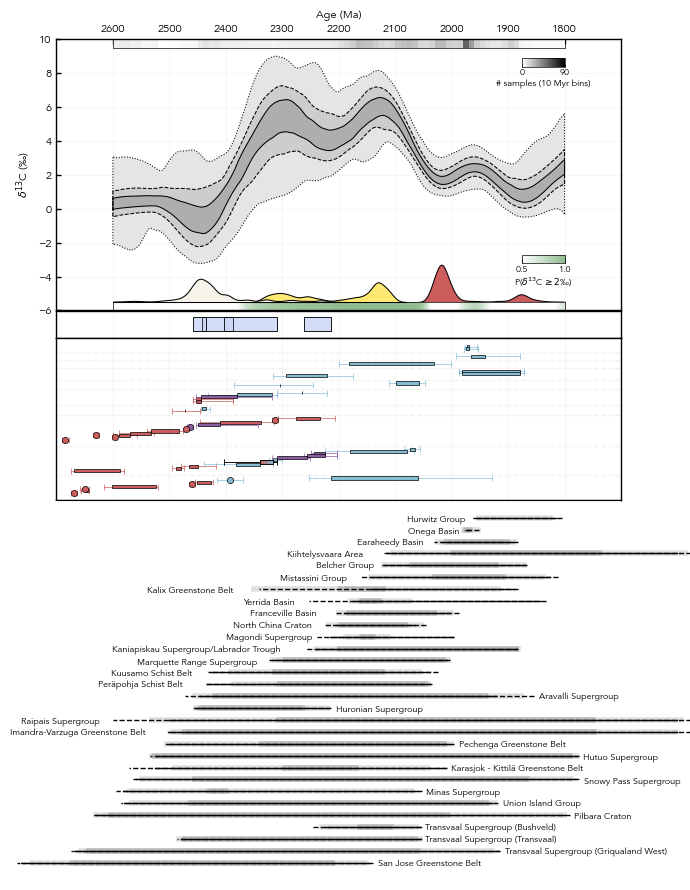

In [38]:
legend = False
plot_proxies = True
plot_glacials = True
plot_onset_dist = True
plot_peak_dist = True
plot_termination_dist = True
plot_p_over_thresh = True
plot_data_density = True
fs = 8


mosaic = """
    2
    2
    2
    2
    2
    2
    2
    2
    2
    2
    4
    3
    3
    3
    3
    3
    3
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    """

fig, ax = plt.subplot_mosaic(mosaic,  figsize = (7, 9), sharex = True, sharey = False) # (7, 8.5) 

ax['2'].tick_params(labeltop = True, top = True, bottom = False, left = True, direction = 'in', labelsize = fs, width = 1)
ax['1'].tick_params(labelbottom = False, bottom = False)
ax['3'].tick_params(bottom = False, direction = 'in')
ax['4'].tick_params(bottom = False, direction = 'in')

ax['2'].xaxis.tick_top()
ax['2'].xaxis.set_label_position('top') 

for axis in ['top','bottom','left','right']:
    ax['2'].spines[axis].set_linewidth(1)
    ax['3'].spines[axis].set_linewidth(1)
    ax['4'].spines[axis].set_linewidth(1)

max_ages = [] 
min_ages = [] 

# plot prior and posterior age range for each basin/supergroup
for i, supergroup in enumerate(supergroup_labels):
    ax['1'].plot([lower_5[supergroup], upper_95[supergroup]], 
                 [i, i], 
                 color = supergroup_pal[i],
                 alpha = 0.25,
                 lw = 4, 
                 zorder = 3, 
                clip_on = False)
    
    ax['1'].plot([lower_50[supergroup], upper_50[supergroup]], 
                 [i, i], 
                 color = supergroup_pal[i], 
                 lw = 4, 
                 alpha = 0.4, 
                 zorder = 4, 
                clip_on = False)
    
    ax['1'].plot([prior_lower_5[supergroup], 
                  prior_upper_95[supergroup]], 
                 [i, i], 
                 lw = 1, 
                 color = 'k', 
                 linestyle = 'dashed', 
                 zorder = 5, 
                clip_on = False)
    
    ax['1'].plot([prior_lower_50[supergroup], prior_upper_50[supergroup]], 
                 [i, i], 
                 lw = 1, 
                 color = 'k', 
                 linestyle = 'solid', 
                 zorder = 6, 
                clip_on = False)
    
    if supergroup == 'Mount Bruce Supergroup':
        supergroup_label = 'Pilbara Craton'
        
    elif supergroup == 'Transvaal Supergroup':
        supergroup_label = 'Transvaal Supergroup (Transvaal)'
    else: 
        supergroup_label = supergroup 
        
    if (i < 15) and (i != 11) and (i != 12):
        ax['1'].text(np.min([prior_lower_5[supergroup], lower_5[supergroup]]) - 8, i - 0.3, supergroup_label, fontsize = 6.5)
        
    elif (i >= 15) or (i == 11) or (i == 12):
        ax['1'].text(np.max([prior_upper_95[supergroup], upper_95[supergroup]]) + len(supergroup) * 9, i - 0.3, supergroup_label, fontsize = 6.5)
    
    max_ages.append(prior_upper_95[supergroup])
    min_ages.append(prior_lower_50[supergroup])
    
ax['1'].spines['right'].set_visible(False)
ax['1'].spines['bottom'].set_visible(False)
ax['1'].spines['left'].set_visible(False)
ax['1'].set_yticks([])

# plot the posterior age range for each of the four Paleoproterozoic glacial events
if plot_glacials: 

    patch = Rectangle((glacial_end['1'], 0.25), # lower left cornner
                    glacial_start['1']-glacial_end['1'],  # width
                    0.5,  # height
                    facecolor = '#C9D5F6', 
                    alpha = 0.8, 
                    lw = 0.5, 
                    edgecolor = 'k', 
                    zorder = 2,
                    clip_on = False) 
    
    ax['4'].add_patch(patch)
    
    patch = Rectangle((glacial_end['1'], 0.25), # lower left cornner
                        glacial_start['1']-glacial_end['1'],  # width
                        0.5,  # height
                        facecolor = 'none', 
                        alpha = 1,
                        lw = 0.5, 
                        edgecolor = 'k', 
                        zorder = 3,
                        clip_on = False) 

    ax['4'].add_patch(patch)
    
    patch = Rectangle((glacial_end['2'], 0.25), # lower left cornner
                        glacial_start['2']-glacial_end['2'],  # width
                        0.5,  # height
                        facecolor = '#C9D5F6', 
                        alpha = 0.8, 
                        lw = 0.5,
                        edgecolor = 'k',
                        zorder = 1,
                        clip_on = False) 
    
    ax['4'].add_patch(patch)
    
    patch = Rectangle((glacial_end['2'], 0.25), # lower left cornner
                        glacial_start['2']-glacial_end['2'],  # width
                        0.5,  # height
                        facecolor = 'none', 
                        alpha = 1,
                        lw = 0.5,
                        edgecolor = 'k',
                        zorder = 2,
                        clip_on = False) 

    ax['4'].add_patch(patch)
    
    
    patch = Rectangle((glacial_end['3'], 0.25), # lower left cornner
                        glacial_start['3']-glacial_end['3'], # width
                        0.5,  # height
                        facecolor = '#C9D5F6', 
                        alpha = 0.8, 
                        lw = 0.5,
                        edgecolor = 'k', 
                        zorder = 1,
                        clip_on = False) 
    
    ax['4'].add_patch(patch)
    
    patch = Rectangle((glacial_end['3'], 0.25), # lower left cornner
                        glacial_start['3']-glacial_end['3'],  # width
                        0.5,  # height
                        facecolor = 'none', 
                        alpha = 1, 
                        lw = 0.5,
                        edgecolor = 'k', 
                        zorder = 2,
                        clip_on = False) 
    
    ax['4'].add_patch(patch)

    
    patch = Rectangle((glacial_end['4'], 0.25), # lower left cornner
                        glacial_start['4']-glacial_end['4'],  # width
                        0.5,  # height
                        facecolor = '#C9D5F6', 
                        alpha = 0.8,
                        lw = 0.5,
                        edgecolor = 'k', 
                        zorder = 1,
                        clip_on = False) 

    ax['4'].add_patch(patch)
    
    patch = Rectangle((glacial_end['4'], 0.25), # lower left cornner
                        glacial_start['4']-glacial_end['4'],  # width
                        0.5,  # height
                        facecolor = 'none', 
                        alpha = 1, 
                        lw = 0.5,
                        edgecolor = 'k', 
                        zorder = 2,
                        clip_on = False) 
    
    ax['4'].add_patch(patch)
    

# plot d13C signal inference with 33, 66, and 95% posterior envelopes
ages = full_trace.X_new.X_new.values
proxy_pred = az.extract(full_trace.posterior_predictive)["f_pred_" + "d13c"].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax["2"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="white",
    edgecolor="none",
    alpha=1,
    lw=0,
    zorder=2,
)

ax["2"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",
    edgecolor="none",
    alpha=0.1, 
    lw=0,
    zorder=3,
)

ax["2"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="dotted",
    edgecolor="k",
    alpha=1,
    lw=0.75,
    zorder=4,
)

hi = np.percentile(proxy_pred, 100 - 17, axis=1).flatten()

lo = np.percentile(proxy_pred, 17, axis=1).flatten()

ax["2"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",
    edgecolor="none",
    alpha=0.1, 
    lw=0,
    zorder=5,
)

ax["2"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="66% envelope",
    edgecolor="k",
    linestyle="dashed",
    alpha=1,
    lw=0.75,
    zorder=6,
)


hi = np.percentile(proxy_pred, 100 - 33.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 33.5, axis=1).flatten()

ax["2"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",
    edgecolor="none",
    alpha=0.15, 
    lw=0,
    zorder=7,
)

ax["2"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="33% envelope",
    edgecolor="k",
    alpha=1,
    lw=0.75,
    linestyle="solid",
    zorder=8,
)

yl = ax['2'].get_ylim()
xl = ax['2'].get_xlim()

min_ages.append(np.min(ages))
max_ages.append(np.max(ages))

ax['2'].set_xlabel('Age (Ma)', fontsize = fs)
ax['2'].set_ylabel(r'$\delta^{13}$C (‰)', fontsize = fs) # $_{\mathrm{carb}}$

ax['2'].set_axisbelow(True)
ax['2'].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle = 'solid', zorder = -10)
       
ax['3'].set_axisbelow(True)
ax['3'].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle = 'solid', zorder = -10, axis = 'x')

ax['4'].set_axisbelow(True)
ax['4'].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle = 'solid', zorder = -10, axis = 'x')

ax['2'].set_xlim([2700, 1700])

# plot KDEs for the onset and termination of the excursion

# set y-position depending on which other plot elements are included
if plot_p_over_thresh: 
    base = -5.5

else: 
    base = -6

# plot onset timing distribution
if plot_onset_dist: 
   
    # extend ylim 
    ax['2'].set_ylim([base, yl[1]])
    
    x = np.linspace(np.min(onset_list), np.max(onset_list), 1000)
    onset_pdf = stats.gaussian_kde(onset_list)(x)
    
    ax['2'].fill_between(x, y1 = base + (onset_pdf * 100), y2 = np.ones(len(x)) * base, color = '#f7f4eb', alpha = 1, edgecolor = 'k', linestyle = 'solid', lw = 0.75, 
                         label = 'LJE onset', zorder = 5)
    
# plot peak timing distribution 
if plot_peak_dist: 
    ax['2'].set_ylim([-6, yl[1]])
    
    x = np.linspace(np.min(peak_list), np.max(peak_list), 1000)
    peak_pdf = stats.gaussian_kde(peak_list)(x)
    
    ax['2'].fill_between(x, y1 = base + (peak_pdf * 100), y2 = np.ones(len(x)) * base, color = '#FFE973', alpha = 1, edgecolor = 'k', linestyle = 'solid', lw = 0.75, label = 'LJE peak', zorder = 3)
    
# plot termination timing distribution
if plot_termination_dist: 
    ax['2'].set_ylim([-6, yl[1]])
    
    x = np.linspace(np.min(termination_list), np.max(termination_list), 1000)
    termination_pdf = stats.gaussian_kde(termination_list)(x)
    
    ax['2'].fill_between(x, y1 = base + (termination_pdf * 100), y2 = np.ones(len(x)) * base, color = 'indianred', alpha = 1, edgecolor = 'k', linestyle = 'solid', lw = 0.75, label = 'LJE termination')

# plot bar with probability that d13C exceeds 2 permil during each time step
if plot_p_over_thresh: 
    ax['2'].set_ylim([-6, yl[1]])
    
    # restrict color map s.t. anything with P<0.5 (50% chance d13C exceeds 2 permil) is white 
    p_d13C = ax['2'].pcolormesh(x_edges_2d_p_d13C, y_edges_2d_p_d13C, p_d13C_thresh.reshape(1, p_d13C_thresh.shape[0]), cmap = p_d13C_thresh_palette, vmin = 0.5, vmax = 1)

    cbaxes_d13C = ax['2'].inset_axes((0.825,0.175, 0.075, 0.03)) # 0.2 with 4 pcolormeshes
    
    cb_d13C = plt.colorbar(p_d13C, cax=cbaxes_d13C, orientation='horizontal', ticks=[0.5, 1], pad = 0)
    cb_d13C.ax.tick_params(labelsize = 6.5, width = 0.5, direction = 'in')
    cb_d13C.set_label(r'P($\delta^{13}$C$\geq2$‰)', fontsize = 6.5, labelpad = 1.5) 
    cb_d13C.outline.set_linewidth(0.5)
    cb_d13C.ax.xaxis.set_ticks_position('bottom')
    cb_d13C.ax.xaxis.set_tick_params(pad=1.5)
    
    patch = Rectangle((1800, -6), # lower left cornner
                    2600-1800,  # width
                    0.5,  # height
                    facecolor = 'none', 
                    alpha = 1,
                    edgecolor = 'k', 
                    lw = 0.5,
                    zorder = 2,
                    clip_on = False) 
    
    ax['2'].add_patch(patch)
    
# plot bar with average posterior d13C observation density
if plot_data_density: 
    ax['2'].set_ylim([-6, 10])
    p = ax['2'].pcolormesh(x_edges_2d, y_edges_2d, hist_included.reshape(1, hist_included.shape[0]), cmap = 'binary', vmin = 0, vmax = 90, zorder = 1) # np.max(hist_included.ravel())
    
    cbaxes = ax['2'].inset_axes((0.825,0.9, 0.075, 0.03))
    
    cb = plt.colorbar(p, cax=cbaxes, orientation='horizontal', ticks=[0.,90], pad = 0)
    cb.ax.tick_params(labelsize = 6.5, width = 0.5, direction = 'in', length = 2)
    cb.ax.xaxis.set_ticks_position('bottom')
    cb.ax.xaxis.set_tick_params(pad=1.5)

    cb.set_label('# samples (10 Myr bins)', fontsize = 6.5, labelpad = 1.5)
    cb.outline.set_linewidth(0.5)
    
    patch = Rectangle((1800, 9.5), # lower left cornner
                        2600-1800,  # width
                        0.5,  # height
                        facecolor = 'none', 
                        alpha = 1, #0.8,
                        edgecolor = 'k', 
                        lw = 0.5,
                        zorder = 2,
                        clip_on = False) 
    
    ax['2'].add_patch(patch)
    
## posterior age range for sulfur isotope observations 

# for each basin, check if the posterior or prior min/max is tighter; plot using tightest constraints
# depositional (co-eval) age constraints take precedence over bounding age constraints
base_value = 0
plotted_depositional = False

# iterate over supergroups/basins
for i, basin in enumerate(include_basins): 
    if i > 0:
        ax['3'].axhline(base_value - 0.75, color = (0.95, 0.95, 0.95), linestyle = 'dashed', lw = 1)
        
    # filter sulfur data by basin
    basin_df = sulfur_data[sulfur_data['Supergroup/Association'] == basin]
    
    basin_formations = basin_df['Formation'].values
    
    basin_levels = basin_df['Stratigraphic order (within basin)'].values
    
    # iterate over formations within supergroup/basin (plotting in stratigraphic order)
    for formation, level in zip(basin_formations, basin_levels):
        value = base_value + 0.4 * (level - 1) 

        formation_df = basin_df[basin_df['Formation'] == formation]
        
        # if there are multiple MIF observations from the same formation (and with the same age constraints), plot as gradient
        if (formation_df.shape[0] != 1) and (len(np.unique(formation_df['Max age'].values)) == 1) and (len(np.unique(formation_df['Min age'].values)) == 1):             
            # check whether age constraints or posterior age models provide tighet constraints on the min/max age of the observation
            # constraints from co-eval sections should be tighter than for older/younger sections, and thus take priority
            if formation_df['Min. posterior age - co-eval (median)'].values[0] > formation_df['Min age'].values[0]:
                min_age = formation_df['Min. posterior age - co-eval (median)'].values[0]
                min_age_std = (formation_df['Min. posterior age - co-eval (median)'].values[0] - formation_df['Min. posterior age (2.5%)'].values[0])/2
            
            elif formation_df['Min. posterior age (median)'].values[0] > formation_df['Min age'].values[0]:
                min_age = formation_df['Min. posterior age (median)'].values[0]
                min_age_std = (formation_df['Min. posterior age (median)'].values[0] - formation_df['Min. posterior age (2.5%)'].values[0])/2
            
            else:
                min_age = formation_df['Min age'].values[0]
                min_age_std = formation_df['Min age std'].values[0]

            if formation_df['Max. posterior age - co-eval (median)'].values[0] < formation_df['Max age'].values[0]:
                max_age = formation_df['Max. posterior age - co-eval (median)'].values[0]
                max_age_std = (formation_df['Max. posterior age - co-eval (97.5%)'].values[0] - formation_df['Max. posterior age - co-eval (median)'].values[0])/2
            
            elif formation_df['Max. posterior age (median)'].values[0] < formation_df['Max age'].values[0]:
                max_age = formation_df['Max. posterior age (median)'].values[0]
                max_age_std = (formation_df['Max. posterior age (97.5%)'].values[0] - formation_df['Max. posterior age (median)'].values[0])/2
            
            else: 
                max_age = formation_df['Max age'].values[0]
                max_age_std = formation_df['Max age std'].values[0]
            
            mean_age = (max_age + min_age)/2
            right_error = (max_age - mean_age) + 2 * max_age_std
            left_error = (mean_age - min_age) + 2 * min_age_std
            xerr = np.array([left_error, right_error]).reshape(2, 1)
            
            (_, caps, _) = ax['3'].errorbar(mean_age, 
                                            value, 
                                            xerr = xerr, 
                                            alpha = 1, #0.1, 
                                            color = 'k', 
                                            lw = 0.5, 
                                            zorder = 7,
                                            capsize = 2,
                                            elinewidth = 0.5, 
                                            clip_on = False)
            
            for cap in caps:
                cap.set_markeredgewidth(0.5)
            
            
            color_list = get_color_list(formation_df, colors)
            
            width = max_age - min_age
            height = 0.6
            
            n = 100 
            cmap1 = LinearSegmentedColormap.from_list("mycmap", color_list, N = n)

            for k in range(n):
                patch = Rectangle((min_age + width/n * k, value - 0.3), # lower left cornner
                                         width/n,  # width
                                           height,  # height
                                           facecolor = cmap1(k), 
                                         alpha = 1, #0.8,
                                          edgecolor = 'none', 
                                           lw = 0,
                                           zorder = 7,
                                          clip_on = False) 
                ax['3'].add_patch(patch)
                    

            ax['3'].add_patch(plt.Rectangle((min_age, value  - 0.3), 
                                          width, 
                                          height, 
                                          facecolor = 'none',
                                          alpha = 1, #0.6,
                                          edgecolor = 'k', 
                                          linewidth=0.5, 
                                          zorder=8))

            
        # if there's only 1 observation for this entry, plot normally
        else: 

            for j in range(formation_df.shape[0]): 
                level_2 = formation_df['Stratigraphic order (within basin)'].values[j]
                
                if level_2 == level:
                    
                    dep_age = formation_df['Depositional age'].values[j]
                    dep_age_std = formation_df['Depositional age std'].values[j]

                    # check whether age constraints or posterior age models provide tighet constraints on the min/max age of the observation
                    # constraints from co-eval sections should be tighter than for older/younger sections, and thus take priority
                    if formation_df['Min. posterior age - co-eval (median)'].values[j] > formation_df['Min age'].values[j]:
                        min_age = formation_df['Min. posterior age - co-eval (median)'].values[j]
                        min_age_std = (formation_df['Min. posterior age - co-eval (median)'].values[j] - formation_df['Min. posterior age - co-eval (2.5%)'].values[j])/2

                    elif formation_df['Min. posterior age (median)'].values[j] > formation_df['Min age'].values[j]:
                        min_age = formation_df['Min. posterior age (median)'].values[j]
                        min_age_std = (formation_df['Min. posterior age (median)'].values[j] - formation_df['Min. posterior age (2.5%)'].values[j])/2

                    else:
                        min_age = formation_df['Min age'].values[j]
                        min_age_std = formation_df['Min age std'].values[j]

                    if formation_df['Max. posterior age - co-eval (median)'].values[j] < formation_df['Max age'].values[j]:
                        max_age = formation_df['Max. posterior age - co-eval (median)'].values[j]
                        max_age_std = (formation_df['Max. posterior age - co-eval (97.5%)'].values[j] - formation_df['Max. posterior age - co-eval (median)'].values[j])/2

                    elif formation_df['Max. posterior age (median)'].values[j] < formation_df['Max age'].values[j]:
                        max_age = formation_df['Max. posterior age (median)'].values[j]
                        max_age_std = (formation_df['Max. posterior age (97.5%)'].values[j] - formation_df['Max. posterior age (median)'].values[j])/2

                    else: 
                        max_age = formation_df['Max age'].values[j]
                        max_age_std = formation_df['Max age std'].values[j]
            
                    classification = formation_df['Classification (MIF or MDF)'].values[j]

                    color = colors[classification]
                    zorder_base = zorder_base_dict[classification]                            

                    label = '_nolabel'

                    # depositional age constraints take priority
                    if ~np.isnan(dep_age):
                        if not plotted_depositional: 
                            dep_label = 'Depositional'
                            plotted_depositional = True

                        else: 
                            dep_label = '_nolabel'

                        (_, caps, _) = ax['3'].errorbar(dep_age, 
                                       value, 
                                       xerr = 2 * dep_age_std, 
                                       alpha = 1, 
                                       color = color, 
                                       lw = 0.5, 
                                       zorder = 8,
                                       capsize = 2,
                                         elinewidth = 0.5, 
                                       clip_on = True)
                        
                        for cap in caps:
                            cap.set_markeredgewidth(0.5)


                        ax['3'].scatter(dep_age, 
                                     value, 
                                 color = color, 
                                   marker = 'o',
                                edgecolor = 'k',
                                   alpha = 1, #0.6,
                                 lw = 0.5,  
                                 zorder = 10, 
                                clip_on = True,
                                s = 20, 
                                  label = dep_label)

                    # if no depositional ages, use min/max range
                    else:
                        mean_age = (max_age + min_age)/2
                        right_error = (max_age - mean_age) + 2 * max_age_std
                        left_error = (mean_age - min_age) + 2 * min_age_std
                        xerr = np.array([left_error, right_error]).reshape(2, 1)

                        (_, caps, _)  = ax['3'].errorbar(mean_age, 
                                     value, 
                                     xerr = xerr,
                                     color = color, 
                                     alpha = 1,
                                     lw = 0.5, 
                                       capsize = 2,
                                         elinewidth = 0.5, 
                                     zorder = zorder_base, 
                                    clip_on = False)
                        
                        for cap in caps:
                            cap.set_markeredgewidth(0.5)

                        age_rect = Rectangle((min_age, value - 0.3), # lower left cornner
                                             max_age - min_age,  # width
                                               0.6,  # height
                                               facecolor = color, 
                                             alpha = 1, #0.6,
                                              edgecolor = 'k', 
                                               lw = 0.5,
                                               zorder = zorder_base + 1,
                                              clip_on = False) 
                                              # label = proxy)

                        ax['3'].add_patch(age_rect)

    base_value += len(np.unique(basin_levels)) * 0.4 + 1
        
        
ax['3'].set_yticks([])
ax['3'].set_yticklabels([])

ax['4'].set_yticks([])
ax['4'].set_yticklabels([])

ax['2'].set_xticks(np.arange(1800, 2601, 100))

fig.tight_layout()

fig.subplots_adjust(hspace = 0.005)

# add a legend
if legend:
    ax['2'].legend(fontsize = fs - 1, loc = 'upper left')

file = 'Fig2'
fig.savefig(str("figures/"+ file +".pdf"), format="pdf", dpi = 500, facecolor='white', transparent=False, bbox_inches='tight', pad_inches=0.2)


## Export d13C signal inference to csv file

In [32]:

summary_d13C = pd.DataFrame(columns = ['Age (Ma)', '2.5%', '5%', '17%', '25%', '50%', '75%', '83%', '95%', '97.5%'])

summary_d13C['Age (Ma)'] = full_trace.X_new.X_new.values

proxy_pred = az.extract(full_trace.posterior_predictive)["f_pred_" + "d13c"].values

summary_d13C['2.5%']  = np.percentile(proxy_pred, 2.5, axis=1).flatten().astype(float)
summary_d13C['5%']  = np.percentile(proxy_pred, 5, axis=1).flatten().astype(float)
summary_d13C['17%']  = np.percentile(proxy_pred, 17, axis=1).flatten().astype(float)
summary_d13C['25%']  = np.percentile(proxy_pred, 25, axis=1).flatten().astype(float)
summary_d13C['50%']  = np.percentile(proxy_pred, 50, axis=1).flatten().astype(float)
summary_d13C['75%']  = np.percentile(proxy_pred, 75, axis=1).flatten().astype(float)
summary_d13C['83%']  = np.percentile(proxy_pred, 83, axis=1).flatten().astype(float)
summary_d13C['95%']  = np.percentile(proxy_pred, 95, axis=1).flatten().astype(float)
summary_d13C['97.5%']  = np.percentile(proxy_pred, 97.5, axis=1).flatten().astype(float)

In [33]:
# summary_d13C.to_csv('data/summary_d13C_curve.csv', index = False)